# Makespan minimization with Constraint Programming (OR-Tools)

In [1]:
import json
import pandas as pd

# Utils
import src.utils.visualization.gantt_diagram as gantt
from src.utils.analysis_basics import check_constraints as check

# Domain data
from src.domain.Query import RoutingQuery
from src.domain.Initializer import JobsInitializer
from src.domain.Collection import LiveJobCollection

# Solver
from src.solvers.CP_Solver import Solver

pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 29)

In [2]:
from configs.path_manager import get_path

# File paths
logs_path = get_path("data", "logs")

### I. Load routing

In [3]:
routings = RoutingQuery.get_by_source_name(source_name="Fisher and Thompson 10x10")

for routing in routings[:2]:
    print(routing)
    for operation in routing.operations:
        print(f" {operation}")

Routing(id='01-00', source_id=1)
 RoutingOperation(routing_id='01-00', position_number=0, machine_name='M01-00', duration=29)
 RoutingOperation(routing_id='01-00', position_number=1, machine_name='M01-01', duration=78)
 RoutingOperation(routing_id='01-00', position_number=2, machine_name='M01-02', duration=9)
 RoutingOperation(routing_id='01-00', position_number=3, machine_name='M01-03', duration=36)
 RoutingOperation(routing_id='01-00', position_number=4, machine_name='M01-04', duration=49)
 RoutingOperation(routing_id='01-00', position_number=5, machine_name='M01-05', duration=11)
 RoutingOperation(routing_id='01-00', position_number=6, machine_name='M01-06', duration=62)
 RoutingOperation(routing_id='01-00', position_number=7, machine_name='M01-07', duration=56)
 RoutingOperation(routing_id='01-00', position_number=8, machine_name='M01-08', duration=44)
 RoutingOperation(routing_id='01-00', position_number=9, machine_name='M01-09', duration=21)
Routing(id='01-01', source_id=1)
 Rout

### II. Create jobs routings (without any change)

In [4]:
jobs = JobsInitializer.create_simple_jobs(routings = routings, shuffle=False)
for job in jobs[:2]:
    print(job)
    for operation in job.operations:
        print(f" {operation}")


Job(id='01-0000', routing_id='01-00', arrival=None, earliest_start=0, deadline=None, sum_duration=395, max_bottleneck_utilization=None)
 JobOperation(job_id='01-0000', position_number=0, machine_name='M01-00', duration=29)
 JobOperation(job_id='01-0000', position_number=1, machine_name='M01-01', duration=78)
 JobOperation(job_id='01-0000', position_number=2, machine_name='M01-02', duration=9)
 JobOperation(job_id='01-0000', position_number=3, machine_name='M01-03', duration=36)
 JobOperation(job_id='01-0000', position_number=4, machine_name='M01-04', duration=49)
 JobOperation(job_id='01-0000', position_number=5, machine_name='M01-05', duration=11)
 JobOperation(job_id='01-0000', position_number=6, machine_name='M01-06', duration=62)
 JobOperation(job_id='01-0000', position_number=7, machine_name='M01-07', duration=56)
 JobOperation(job_id='01-0000', position_number=8, machine_name='M01-08', duration=44)
 JobOperation(job_id='01-0000', position_number=9, machine_name='M01-09', duration

In [5]:
jobs_collection = LiveJobCollection(jobs)
print(f"Total number of operations: {jobs_collection.count_operations()}")

Total number of operations: 100


## Scheduling

In [6]:
solver = Solver(
    jobs_collection = jobs_collection,
    schedule_start= 0
)
solver.build_makespan_model()

In [7]:
model_log = solver.get_model_info()
print(json.dumps(model_log, indent=2))

{
  "number_of_operations_to_schedule": 100,
  "number_of_operations_with_previous_schedule": 0,
  "number_of_active_operation_to_consider": 0,
  "number_of_variables": 201,
  "number_of_constraints": 220
}


In [8]:
log_file_path = logs_path / "makespan_cp.log"


solver.solve_model(
    log_file= log_file_path
)

In [9]:
solver_info = solver.get_solver_info()
print(json.dumps(solver_info, indent=2))

{
  "status": "OPTIMAL",
  "objective_value": 930.0,
  "best_objective_bound": 930.0,
  "number_of_branches": 0,
  "wall_time": 3.41
}


In [10]:
schedule_job_collection = solver.get_schedule()
df_schedule = schedule_job_collection.to_operations_dataframe()
df_schedule

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Ready Time,Deadline
0,01-0000,01-00,0,M01-00,0,29,29,0,None
1,01-0000,01-00,1,M01-01,446,78,524,0,None
2,01-0000,01-00,2,M01-02,524,9,533,0,None
3,01-0000,01-00,3,M01-03,535,36,571,0,None
4,01-0000,01-00,4,M01-04,571,49,620,0,None
5,01-0000,01-00,5,M01-05,644,11,655,0,None
6,01-0000,01-00,6,M01-06,655,62,717,0,None
7,01-0000,01-00,7,M01-07,721,56,777,0,None
...,...,...,...,...,...,...,...,...,...
92,01-0009,01-09,2,M01-02,364,61,425,0,None


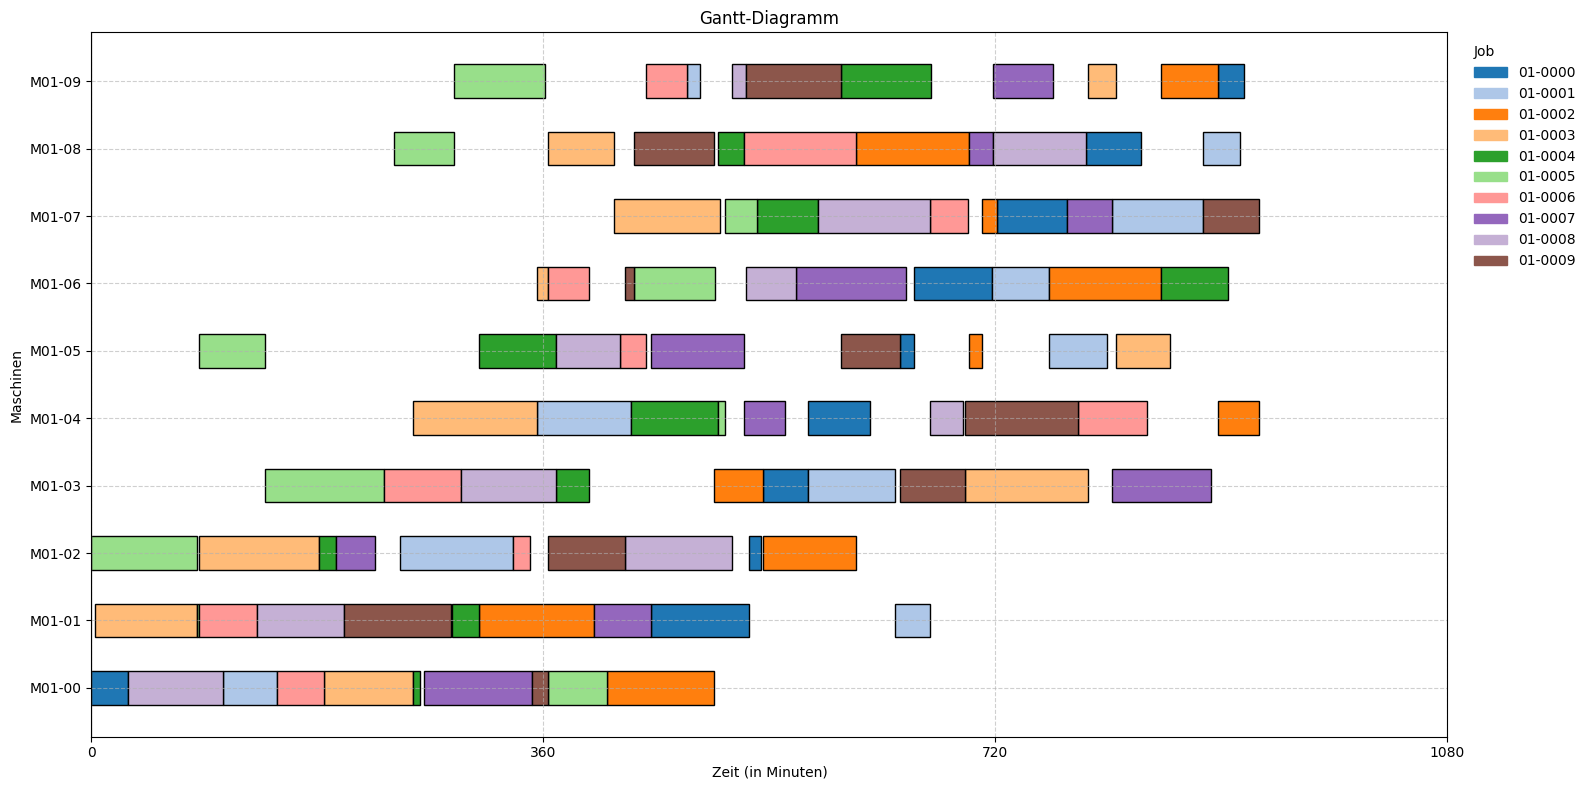

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All durations match the difference between start and end.


True

In [11]:
gantt.get_plot(df_schedule, perspective="Machine")
check.check_core_schedule_constraints(df_schedule)
# check.is_start_correct(df_schedule, df_jobs_arrivals)
check.is_duration_correct(df_schedule)